In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
# Hyper-parameter
batch_size = 100

# Load the MNIST dataset with torchvision 
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [0]:
#model

import torch.nn as nn

class AlexNet(nn.Module):
	def __init__(self, num_classes=10):
		super(AlexNet, self).__init__()

		#self.num_classes = num_classes

		self.conv1 = nn.Conv2d(in_channels=1, out_channels=784, kernel_size=3, stride=4, padding=1)
		self.relu = nn.ReLU(inplace=True)
		self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
		self.conv2 = nn.Conv2d(in_channels=784, out_channels=392, kernel_size=3, padding=1)
		self.conv3 = nn.Conv2d(in_channels=392, out_channels=256, kernel_size=3, padding=1)
		self.conv4 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
		self.conv5 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
		self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
		self.dropout = nn.Dropout()
		self.ff1 = nn.Linear(64*4*4, 120)
		self.ff2 = nn.Linear(120, 120)
		self.output = nn.Linear(120, num_classes)

	def forward(self, x):
		# First Convolutional Layer
		y = self.conv1(x)
		y = self.relu(y)
		y = self.maxpool(y)

		# Second Convolutional Layer
		y = self.conv2(y)
		y = self.relu(y)
		y = self.maxpool(y)

		# Third Convolutional Layer
		y = self.conv3(y)
		y = self.relu(y)

		# Fourth Convolutional Layer
		y = self.conv4(y)
		y = self.relu(y)

		# Fifth Convolutional Layer
		y = self.conv5(y)
		y = self.relu(y)
		#y = self.maxpool(y)
		y = self.avgpool(y)

		# Flattening 
		y = y.view(y.size(0), 64*4*4)

		# First Feed Forward Layer
		y = self.dropout(y)
		y = self.ff1(y)
		y = self.relu(y)

		# Second Feed Forward Layer
		y = self.dropout(y)
		y = self.ff2(y)
		y = self.relu(y)

		# Output Layer
		y = self.output(y)
		return y

In [0]:
#hyper-parameters
num_epochs = 3
num_classes = 10
batch_size = 100
learning_rate = 0.001

In [0]:
#initiating the model
model = AlexNet(num_classes).to(device)

model

AlexNet(
  (conv1): Conv2d(1, 784, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1))
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(784, 392, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(392, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool): AdaptiveAvgPool2d(output_size=(4, 4))
  (dropout): Dropout(p=0.5)
  (ff1): Linear(in_features=1024, out_features=120, bias=True)
  (ff2): Linear(in_features=120, out_features=120, bias=True)
  (output): Linear(in_features=120, out_features=10, bias=True)
)

In [0]:
#construct loss function and optimizer

#cross Entropy Loss
criterion = nn.CrossEntropyLoss()

#SGD
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
# Train the model
losses = []


for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        #move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        #forward pass
        outputs = model(images)
        
        #computing the loss
        loss = criterion(outputs, labels)
    
        #computing gradient and update model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    losses.append(loss.item())
    print("Epoch:", epoch, "loss:", loss.item())

Epoch: 0 loss: 0.9459404945373535
Epoch: 1 loss: 0.3378700613975525
Epoch: 2 loss: 0.24415847659111023


Text(0.5, 0, 'epoch')

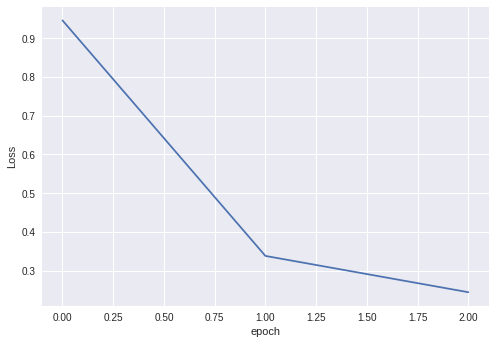

In [0]:
plt.plot(range(num_epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch')

In [0]:
#test the model

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of ', len(train_dataset), ' train images: {} %'.format(100 * correct / total))
    
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of ', len(test_dataset), ' test images: {} %'.format(100 * correct / total))

Test Accuracy of  60000  train images: 92.98666666666666 %
Test Accuracy of  10000  test images: 93.04 %
